### Summary Statistics and Visualizations 

We begin by reading the data and summarizing the variables.

In [1]:
#%% Import necessary libraries
from nbeats_lightning.nbeats import *
from nbeats_lightning.loaders import *
import pandas as pd
import lightning.pytorch as pl
from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import loggers as pl_loggers
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
tqdm.pandas()
%matplotlib inline

import tensorboard
import warnings
warnings.filterwarnings('ignore')

# Load the milk.csv dataset
milk = pd.read_csv('data/milk.csv', index_col=0)
milkval = milk.values.flatten() # flat numpy array
milk.head()

c:\Users\DanielByrne\AppData\Local\miniconda3\envs\nbeats_lightning\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


,milk_production_pounds
month,
1962-01,589
1962-02,561
1962-03,640
1962-04,656
1962-05,727


The dataset consists of two columns:

- *month:*  The month during which the data was collected, starting from January 1962.
- *milk_production_pounds:*   The amount of milk produced in pounds.


In [2]:
milk.describe()

,milk_production_pounds
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


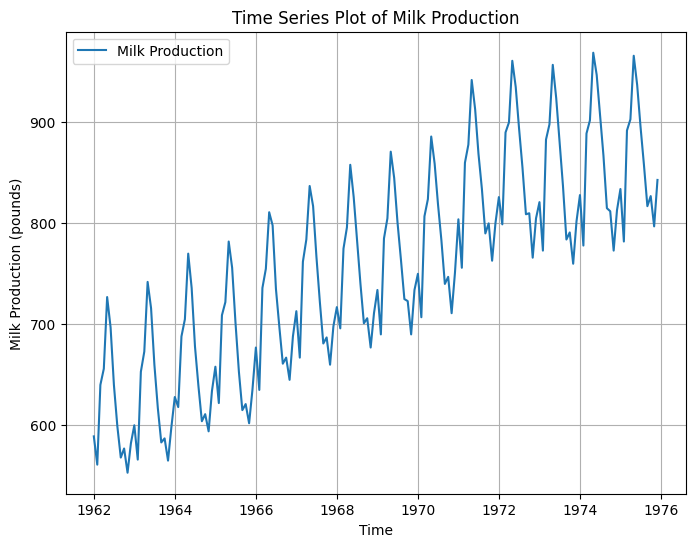

In [3]:
# Convert the 'month' column to datetime format
milk['month'] = pd.to_datetime(milk.index)

# Create Time Series Plot
plt.figure(figsize=(8, 6))
plt.plot(milk['month'], milk['milk_production_pounds'], label='Milk Production')
plt.title('Time Series Plot of Milk Production')
plt.xlabel('Time')
plt.ylabel('Milk Production (pounds)')
plt.legend()
plt.grid(True)
plt.show()


The Time Series Plot above illustrates the trend and seasonality in milk production over time.
It's apparent that there's a recurring pattern every year, which suggests a strong seasonal
component. Additionally, there seems to be a general upward trend in milk production over the years.
Next, let's move on to the Seasonal Decomposition to decompose the time series into its trend,
seasonal, and residual components. This will provide a clearer picture of the underlying patterns
in the data.

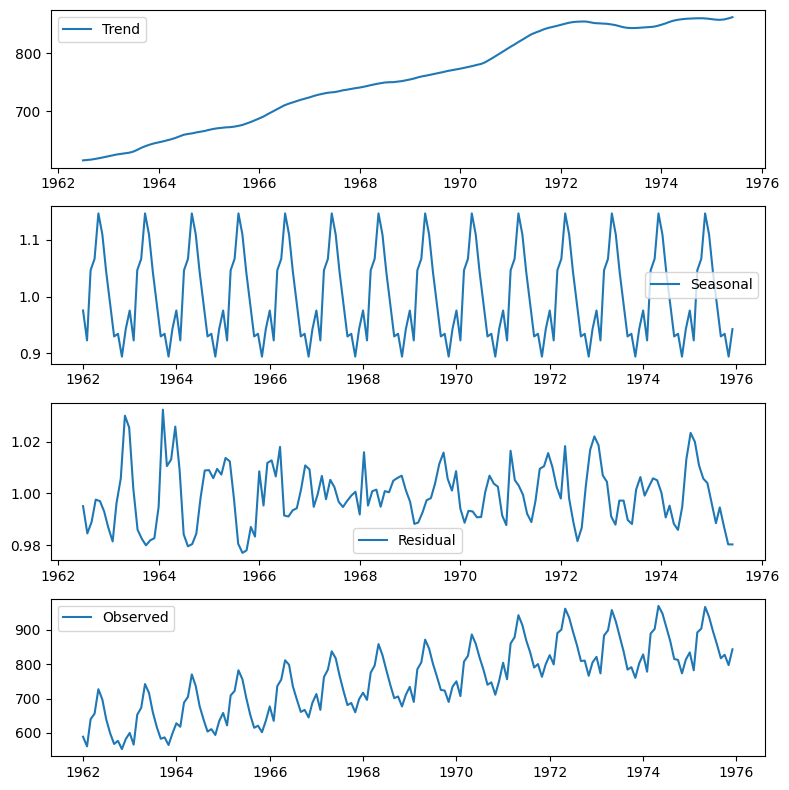

In [4]:
milk.set_index('month', inplace=True)

# Perform seasonal decomposition
decomposition = seasonal_decompose(milk['milk_production_pounds'], model='multiplicative')

# Plot the seasonal decomposition again with the corrected attribute name
plt.figure(figsize=(8, 8))
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(milk['milk_production_pounds'], label='Observed')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


The Seasonal Decomposition plot breaks down the time series into three components:

* Trend: Shows a general upward trend in milk production over the years.
* Seasonal: Illustrates a clear seasonal pattern that repeats every year.
* Residual: Contains the residual values after the trend and seasonal components have
been removed.

### Model Specification

Next we will create a PyTorch Lightning DataModule to load the data, and 3 nbeats_lightning models, 2 generic, and 1 interpretable, with which to train the data and then predict.  We will then compare the predictions of the two models
against the actual data and to each other.

In [5]:
#%% Define the Generic N-Beats Models
# Generic hyperparameters
forecast_length = 6
backcast_length = 4 * forecast_length
batch_size = 64
g_stacks = 6

g_blocks_per_stack = 1
g_width = 512


# Create a simple pytorch dataloader
dm = TimeSeriesDataModule(
  data=milkval,
  batch_size=batch_size,
  backcast=backcast_length,
  forecast=forecast_length)

# A Generic N-Beats Model.  
# - 6 stacks
#   - 1 generic() block per stack 
#     - 5 waveform theta parameters per block

stack_types = [NBeatsNet.VAE] * g_stacks
g1 = NBeatsNet (
  backcast = backcast_length,
  forecast = forecast_length, 
  generic_architecture = True,
  n_blocks_per_stack = g_blocks_per_stack,
  n_stacks = g_stacks,
  share_weights = False, # share initial weights
  g_width = g_width)



In [7]:
# Define a model checkpoint callback
g1_chk_callback = ModelCheckpoint(
  save_top_k = 2, # save top 2 models
  monitor = "val_loss", # monitor validation loss as evaluation 
  mode = "min",
  filename = "{name}-{epoch:02d}-{val_loss:.2f}",
)

# Define a tensorboard loger
name = f"Generic-[{backcast_length}-{forecast_length}]-s[{g_stacks}-{g_blocks_per_stack}]-w[{g_width}]" 
print("Model Name :", name)
g1_tb_logger = pl_loggers.TensorBoardLogger(save_dir="lightning_logs/", name=name)


# Train the generic model
generic_trainer =  pl.Trainer(
  accelerator='auto' # use GPU if available
  ,max_epochs=1000
  ,callbacks=[g1_chk_callback]  
  ,logger=[g1_tb_logger]
)

generic_trainer.fit(g1, datamodule=dm)
generic_trainer.validate(g1, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Model Name : Generic-[24-6]-s[6-1]-w[512]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | loss_fn | SMAPELoss  | 0     
1 | stacks  | ModuleList | 4.8 M 
---------------------------------------
4.8 M     Trainable params
2.7 K     Non-trainable params
4.8 M     Total params
19.345    Total estimated model params size (MB)


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 53.32it/s, v_num=1, train_loss=1.390, val_loss=1.380] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 2/2 [00:00<00:00, 51.93it/s, v_num=1, train_loss=1.390, val_loss=1.380]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 166.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.3812669515609741     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.3812669515609741}]

In [ ]:
# Predict
historical_data = torch.tensor(milkval[-backcast_length - forecast_length:- forecast_length], dtype=torch.float32).view(1, -1)

# Create forecasting dataloader
predict_dataset = ForecastingDataset(historical_data)
predict_dataloader = DataLoader(predict_dataset, batch_size=1)

# The model uses a ptl trainer to predict
g1_predictions = generic_trainer.predict(g1, dataloaders=predict_dataloader)


# The trainer returns a list of dictionaries, one for each dataloader passed to trainer.predict.  We only want the first and only one.
g1_predictions = g1_predictions[0].squeeze()



Set the date range of the precicitons to be the last quarter of the validation data. Also we will only plot a subset of the the data for ease of viewing.

In [ ]:
#%%
predicted_months = pd.date_range(start="1975-06", periods=forecast_length, freq='M').strftime('%Y-%m')
g1_df = pd.DataFrame(g1_predictions, index=predicted_months)
g2_df = pd.DataFrame(g2_predictions, index=predicted_months)


# Plot a subset of the data
interpretable_df = pd.DataFrame(interpretable_predictions, index=predicted_months)
milk_subset = milk[milk.index > '1971-01']
milk_subset.index=milk_subset.index.strftime('%Y-%m')

Use Matplotlib to plot the predictions of the models against the actual data.

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(milk_subset.index, milk_subset['milk_production_pounds'], marker='o', linestyle='-', color='b')
plt.plot(g1_df.index, g1_df, marker='o', linestyle='-', color='g')
plt.plot(g2_df.index, g2_df, marker='o', linestyle='-', color='lightgreen')
plt.plot(interpretable_df.index, interpretable_df, marker='o', linestyle='-', color='indigo')
plt.title('Milk Production Over Time (1971-1975)', fontsize=14)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Milk Production (lbs)', fontsize=12)
plt.grid(True)
plt.xticks([])
plt.tight_layout()
plt.show()
